In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import plotly.graph_objects as go
from plotly.offline import iplot

In [3]:
import os
import numpy as np
import scipy
import scipy.optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab.patches import cv2_imshow
import cv2

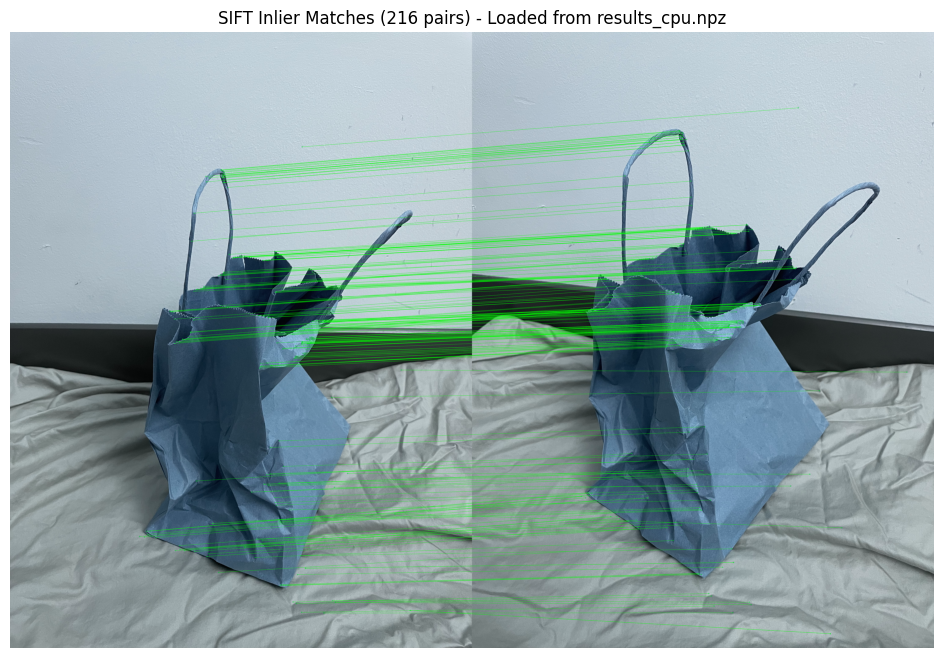

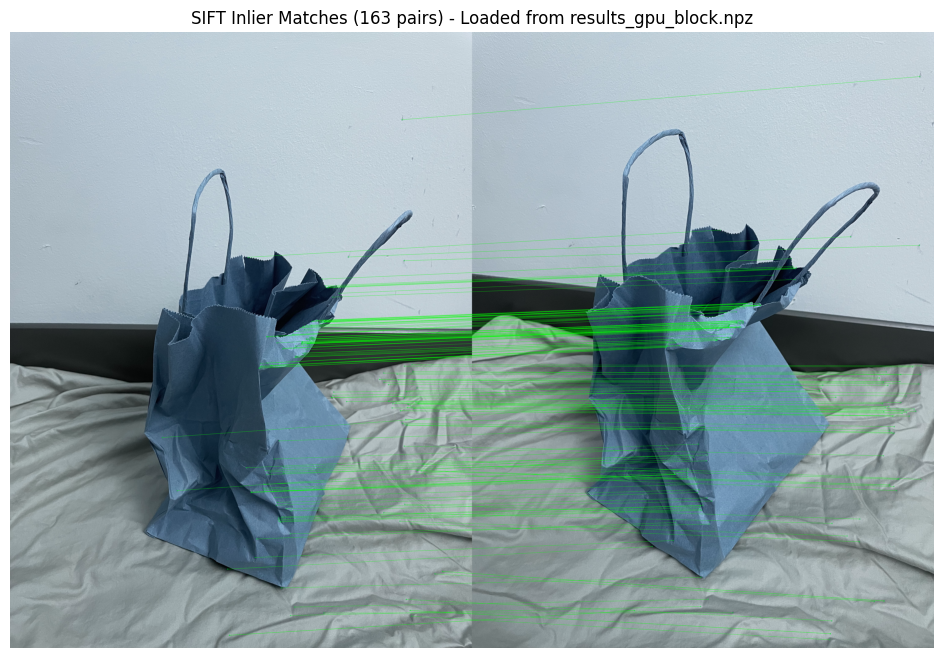

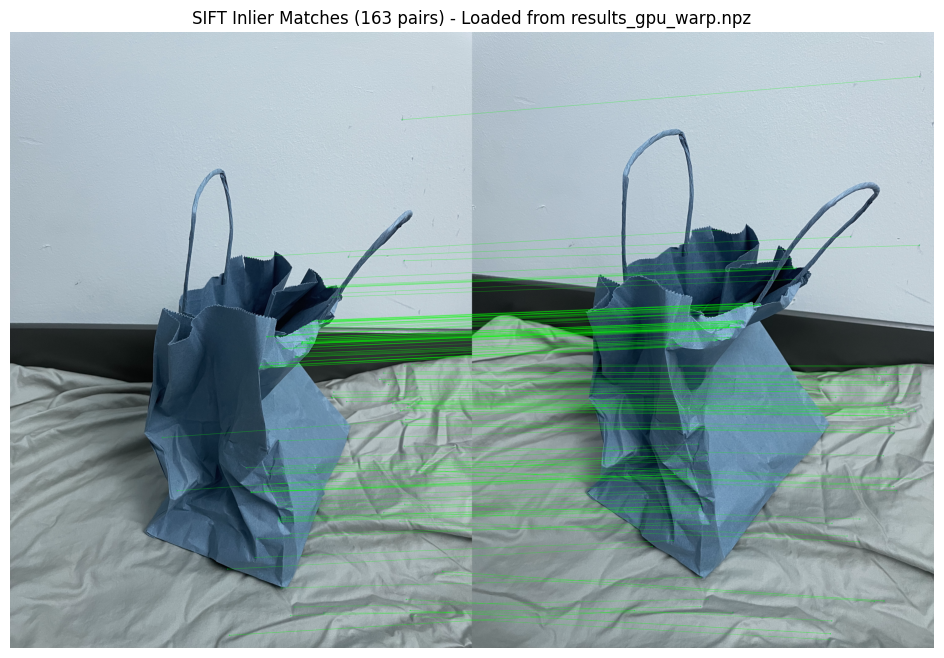

In [5]:
def plot_saved_results(npz_path):
    # 1. Load the data
    if not os.path.exists(npz_path):
        print(f"File {npz_path} not found.")
        return

    data = np.load(npz_path)
    img1 = data['img1']
    img2 = data['img2']
    pts1 = data['pts1']
    pts2 = data['pts2']

    # 2. Reconstruct KeyPoints from raw coordinates
    # Since pts1 and pts2 are already aligned inliers (pts1[i] matches pts2[i]),
    # we create keypoints solely at those locations.
    kp1 = [cv2.KeyPoint(x=float(p[0]), y=float(p[1]), size=10) for p in pts1]
    kp2 = [cv2.KeyPoint(x=float(p[0]), y=float(p[1]), size=10) for p in pts2]

    # 3. Reconstruct Matches
    # Because the arrays are aligned, match i in kp1 connects to match i in kp2
    matches = [cv2.DMatch(_queryIdx=i, _trainIdx=i, _imgIdx=0, _distance=0) for i in range(len(pts1))]

    # 4. Visualization (Your original logic)
    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=(255, 0, 0),
                       flags=cv2.DrawMatchesFlags_DEFAULT)

    # Note: Using DrawMatches directly here
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **draw_params)

    # Convert BGR (OpenCV standard) to RGB (Matplotlib standard)
    img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 8))
    plt.imshow(img_matches_rgb)
    plt.title(f"SIFT Inlier Matches ({len(matches)} pairs) - Loaded from {npz_path}")
    plt.axis('off')
    plt.show()

# Example Usage in Colab:
# Upload 'results_gpu.npz' to your Colab files first
import os
plot_saved_results('results_cpu.npz')
plot_saved_results('results_gpu_block.npz')
plot_saved_results('results_gpu_warp.npz')

In [6]:
def plot_saved_results(filename, title="3D Reconstruction"):
    """
    Loads a .npz file exported from the pipeline and plots the 3D points
    interactively using Plotly.

    Args:
        filename (str): Path to the .npz file (e.g., 'results_cpu.npz')
        title (str): Title for the plot
    """
    if not os.path.exists(filename):
        print(f"File {filename} not found.")
        return

    print(f"Loading {filename}...")
    try:
        data = np.load(filename)
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return

    # Extract data
    # Note: Images were saved as RGB in the pipeline script
    if 'img1' not in data or 'pts1' not in data or 'P' not in data:
        print(f"Error: {filename} missing required keys (img1, pts1, or P).")
        return

    img1 = data['img1']
    pts1 = data['pts1']
    P = data['P']

    if len(P) == 0:
        print(f"No 3D points found in {filename}.")
        return

    print(f"Plotting {len(P)} points for {title}...")

    # 1. Extract Colors from Image 1 using Feature Points
    # pts1 contains float coordinates, round to nearest int for indexing
    pts1_int = np.round(pts1).astype(int)

    # Clip indices to ensure they are within image bounds (safety check)
    h, w, _ = img1.shape
    pts1_int[:, 0] = np.clip(pts1_int[:, 0], 0, w - 1)
    pts1_int[:, 1] = np.clip(pts1_int[:, 1], 0, h - 1)

    # Get RGB values
    # Numpy array indexing is [row (y), col (x)]
    P_colors_rgb = img1[pts1_int[:, 1], pts1_int[:, 0]]

    # Convert to Plotly color format string: 'rgb(r,g,b)'
    P_colors_plotly = [f'rgb({r},{g},{b})' for r, g, b in P_colors_rgb.tolist()]

    # 2. Create Plotly Trace
    trace = go.Scatter3d(
        x=P[:, 0],
        y=P[:, 1],
        z=P[:, 2],
        mode='markers',
        marker=dict(
            size=3,
            color=P_colors_plotly,
            opacity=0.8
        ),
        name=title
    )

    # 3. Layout
    layout = go.Layout(
        title=title,
        margin=dict(l=0, r=0, b=0, t=30),
        scene=dict(
            xaxis_title='X World Coordinate',
            yaxis_title='Y World Coordinate',
            zaxis_title='Z World Coordinate',
            aspectmode='data' # Ensures uniform scaling in all directions
        )
    )

    # 4. Show
    fig = go.Figure(data=[trace], layout=layout)
    fig.show()

plot_saved_results("results_cpu.npz", title="CPU Reconstruction")
plot_saved_results("results_gpu_block.npz", title="GPU Block Reconstruction")
plot_saved_results("results_gpu_warp.npz", title="GPU Warp Reconstruction")

Loading results_cpu.npz...
Plotting 216 points for CPU Reconstruction...


Loading results_gpu_block.npz...
Plotting 163 points for GPU Block Reconstruction...


Loading results_gpu_warp.npz...
Plotting 163 points for GPU Warp Reconstruction...
